In [17]:
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import datetime

# 0 - Functions 

Function to plot the accuracy metrics (F1 score)

In [18]:
def plot_f1(classif_report):
    am_df = pd.DataFrame.from_dict(classif_report).round(3) 
    am_df = am_df.iloc[:,:-3]
    am_df = am_df.sort_values(by='support', ascending=False, axis=1)
    class_name = am_df.columns.to_list()
    f1_score  = am_df.loc['f1-score'].to_list()
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax.bar(class_name, f1_score, tick_label=class_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

Functions to plot the results of the classification (Confusion matrix and plot of F1 score)

In [19]:
def show_results(clf, X_test, y_test):
    predictions = clf.predict(X_test)

    classif_report = classification_report(y_test, predictions, zero_division=0, output_dict=True)

    print(classification_report(y_test, predictions, zero_division=0))
    fig, ax = plt.subplots(figsize=(20, 20), facecolor='white')
    plot_confusion_matrix(clf, X_test, y_test, ax=ax, xticks_rotation=90, cmap='Blues')
    plot_f1(classif_report)

def show_results_RF(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    show_results(clf, X_test, y_test)

Function to plot the results of the classification (on a map)

In [20]:
def plot_preds(parcels_used, y_test, predictions):
    parcels_test = parcels_used.loc[y_test.index]
    parcels_test['preds'] = predictions
    
    classes = sorted(y_test.unique().tolist())
    colors = cm.nipy_spectral(np.linspace(0, 1, len(classes)))
    

    fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
    for i in range(len(classes)):
        par_class = parcels_test[parcels_test['preds'] == classes[i]]
        if len(par_class) > 0:
            par_class.plot(ax=ax, label=classes[i], color=colors[i])

### Parameters

Set directories

In [21]:
path = '/export/projects/Trainings/ESA_LTC_2022_Diane/'
features_file = f'{path}Training_features_CropType_AOIBelgium2021_long.csv'
lut_file = f'{path}LUT_Wallonia_2021_Training.csv'
parcels_file = f'{path}AOI_Training/AOI_Training_Belgium_2021.shp'

# 1 - Import features in the environment

## 1.1 - Import parcels 

The shapefile that contains the parcels is imported. It has 
- attributes related to geometries (number of Sentinel-1 pixel - S1Pix, the surface mesured - Area_meters, ...) 
- attributes related to the crop types declared (ctnum and ct)

In [22]:
parcels = gpd.read_file(parcels_file)
parcels.head()

NewID  GeomValid  Duplic  Overlap  Area_meter  ShapeInd  S1Pix  S2Pix  \
0  282287          1       0        0     2019.75   3.92265      0      0   
1  284951          1       0        0     2170.65   2.99733      0      0   
2  286928          1       0        0    95000.10   1.15844    330   1396   
3  231257          1       0        0     1487.72   4.69621      0      0   
4  232421          1       0        0     2048.48   2.47013      0      0   

   ctnum                ct                                           geometry  
0     58       strip grass  POLYGON ((206024.000 150130.417, 206105.500 15...  
1     58       strip grass  POLYGON ((196260.750 151369.750, 196250.200 15...  
2     21      Winter wheat  POLYGON ((200985.125 135940.875, 200901.625 13...  
3     60            fallow  POLYGON ((207149.500 137632.000, 207149.905 13...  
4     57  grassed headland  POLYGON ((198414.000 139217.667, 198441.667 13...

Plot parcels in AOI

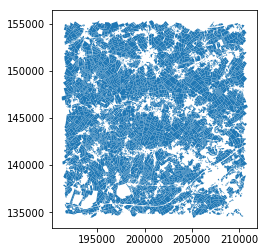

In [23]:
parcels.plot()

## 1.2 - Import Features

Import features extracted at the parcel level in the columns names. There are
- the dates,
- the sensors (s2),
- the metrics (mean or std),
- and the bands (ex. b11, b4, ndvi,.)

How many features are available in the feature dataset ?

In [24]:
features = pd.read_csv(features_file)
features.head()

NewID  XX_2021_01_08_s2_mean_b3  XX_2021_01_08_s2_mean_b4  \
0     49                994.726013               1212.260010   
1    100                872.190002                894.237976   
2    101                678.534973                702.968994   
3    126               1659.359985               1493.219971   
4    127                878.000000                661.190979   

   XX_2021_01_08_s2_mean_b8  XX_2021_01_08_s2_mean_b11  \
0               2109.719971                1925.369995   
1               2197.260010                1965.770020   
2               2151.449951                1958.439941   
3               4383.589844                1296.819946   
4               4410.990234                1758.930054   

   XX_2021_01_08_s2_mean_ndvi  XX_2021_01_08_s2_mean_ndwi  \
0                    0.269728                   -0.045214   
1                    0.421186                   -0.055023   
2                    0.494610                   -0.036615   
3                    0.496679                   -0.540962   
4                    0.737079                   -0.428628   

   XX_2021_01_08_s2_mean_brightness  XX_2021_01_18_s2_mean_b3  \
0                       3260.179932                994.726013   
1                       3202.469971                872.190002   
2                       3086.719971                678.534973   
3                       5138.330078               1659.359985   
4                       4890.140137                878.000000   

   XX_2021_01_18_s2_mean_b4  ...  XX_2021_12_14_s2_dev_ndvi  \
0               1212.260010  ...                   0.047412   
1                894.237976  ...                   0.050355   
2                702.968994  ...                   0.055144   
3               1493.219971  ...                   0.062435   
4                661.190979  ...                   0.042385   

   XX_2021_12_14_s2_dev_ndwi  XX_2021_12_14_s2_dev_brightness  \
0                   0.031975                       229.296997   
1                   0.064653                       565.340027   
2                   0.054063                       345.598999   
3                   0.088133                      1092.390015   
4                   0.058958                       598.981995   

   XX_2021_12_24_s2_dev_b3  XX_2021_12_24_s2_dev_b4  XX_2021_12_24_s2_dev_b8  \
0                42.032101                49.114399               292.446991   
1                73.703201                66.009003               501.625000   
2               138.794998               119.455002               245.589005   
3               120.459000                93.641502              1111.089966   
4                70.146400                63.610401               628.830017   

   XX_2021_12_24_s2_dev_b11  XX_2021_12_24_s2_dev_ndvi  \
0                 77.220001                   0.049008   
1                 57.621101                   0.054646   
2                146.843994                   0.054796   
3                265.587006                   0.083458   
4                234.050995                   0.051745   

   XX_2021_12_24_s2_dev_ndwi  XX_2021_12_24_s2_dev_brightness  
0                   0.035080                       271.385010  
1                   0.068431                       481.427002  
2                   0.053766                       301.502014  
3                   0.098230                      1115.109985  
4                   0.066047                       633.008972  

[5 rows x 505 columns]

## 1.3 - Import crops information

The list of crop types in one region can be heavy, grouping the similar crop type in terms of agricultural purpose and signature signal is a key for a good classification

In [25]:

lut = pd.read_csv(lut_file)
lut.rename(columns={'CT':'ct'}, inplace=True)
lut.head()

Ctnum                                                 ct  LC  CTnumGrp  \
0      2                                          Buckwheat   1        37   
1      3                               Cereals + leguminous   1        39   
2     36  Mixture of winter cereals (more than 50%) and ...   1        39   
3     38                         Winter cereal mixture only   1        39   
4     44  Winter leguminous mixture (more than 50%) + ce...   1        39   

                     Group  
0                Buckwheat  
1  Mix Cereals and Legumes  
2  Mix Cereals and Legumes  
3  Mix Cereals and Legumes  
4  Mix Cereals and Legumes

## 1.4 - Preparation of the parcels

Assert that each NewID is unique

In [26]:
assert not parcels['NewID'].duplicated().any()
assert not features['NewID'].duplicated().any()

Add a column with 'Group' which is the label used for classification

In [27]:
parcels_group = pd.merge(parcels, lut[['ct','Group']], on='ct')

# & Set NewID as index
features.set_index('NewID', inplace=True)
parcels_group.set_index('NewID', inplace=True)
parcels_group.head()

GeomValid  Duplic  Overlap  Area_meter  ShapeInd  S1Pix  S2Pix  ctnum  \
NewID                                                                           
282287          1       0        0     2019.75   3.92265      0      0     58   
284951          1       0        0     2170.65   2.99733      0      0     58   
263572          1       0        0     1640.31   3.95510      0      0     58   
265172          1       0        0     3205.66   5.49917      0      0     58   
267208          1       0        0     2940.32   5.73226      0      0     58   

                 ct                                           geometry  \
NewID                                                                    
282287  strip grass  POLYGON ((206024.000 150130.417, 206105.500 15...   
284951  strip grass  POLYGON ((196260.750 151369.750, 196250.200 15...   
263572  strip grass  POLYGON ((198345.375 138513.250, 198350.336 13...   
265172  strip grass  POLYGON ((199398.246 139616.097, 199402.449 13...   
267208  strip grass  POLYGON ((198569.098 139034.891, 198570.916 13...   

               Group  
NewID                 
282287  Buffer strip  
284951  Buffer strip  
263572  Buffer strip  
265172  Buffer strip  
267208  Buffer strip

Some parcels were too small in the AOI and so no features were extracted for those parcels


In [28]:
# Keep only parcels that are in features 
indices_used = features.index
parcels_used = parcels_group.loc[indices_used]
parcels_used.head()

GeomValid  Duplic  Overlap  Area_meter  ShapeInd  S1Pix  S2Pix  ctnum  \
NewID                                                                          
49             1       0        0    21488.10   1.21676     39    190     21   
100            1       0        0     5929.78   1.41838      6     42     30   
101            1       0        0    27127.40   1.55601     46    228     72   
126            1       0        0    18704.50   1.56902     30    148     49   
127            1       0        0    17409.80   1.52401     27    141     49   

                                                      ct  \
NewID                                                      
49                                          Winter wheat   
100                                     Winter triticale   
101                                           Vegetables   
126    Permanent meadow (coverage > 90%); out of rota...   
127    Permanent meadow (coverage > 90%); out of rota...   

                                                geometry             Group  
NewID                                                                       
49     POLYGON ((203251.000 140345.583, 203239.333 14...     Winter Cereal  
100    POLYGON ((197266.375 139252.875, 197370.508 13...     Winter Cereal  
101    POLYGON ((196944.000 138447.000, 196972.764 13...  Other vegetables  
126    POLYGON ((207400.125 141937.875, 207414.500 14...         Grassland  
127    POLYGON ((207538.667 141966.333, 207542.500 14...         Grassland

Move all classes (Group) that have less than 10 samples to a new class called 'Others'

In [29]:
ct_counts = parcels_used['Group'].value_counts()
ct_counts_small = ct_counts[ct_counts < 10]
parcels_used['New_Group'] = parcels_used['Group']
parcels_used.loc[parcels_used['Group'].isin(ct_counts_small.index), 'New_Group'] = 'Others'

# 2 - Plot Time Series

In [30]:
# For plotting NDVI 
ndvi_cols = [col for col in features.columns if 'mean_ndvi' in col]
ndvi_feat = features[ndvi_cols]

In [31]:
parcels_used.New_Group.unique()

array(['Winter Cereal', 'Other vegetables', 'Grassland', 'Potato',
       'Other green cover', 'Flax (linseed)', 'Maize', 'Carrots',
       'Green beans', 'Fallow', 'Chicory', 'Sugar beet',
       'Mix Cereals and Legumes', 'Permanent crop', 'Peas',
       'Spring Cereal', 'Buffer strip', 'Rapeseed', 'Other cover',
       'Others', 'Plant nursery of fruit plants or ornamental plants',
       'Onions'], dtype=object)

In [32]:
color_list = ['lightsteelblue', 'lightsalmon', 'palegreen','plum', 'moccasin', 'lightpink', 'silver', 'limegreen']

Define a crop type and see the NDVI time series
> The blue line is the mean of all the parcel at each date

> Each parcel is represented according to the initial crop type of the training dataset

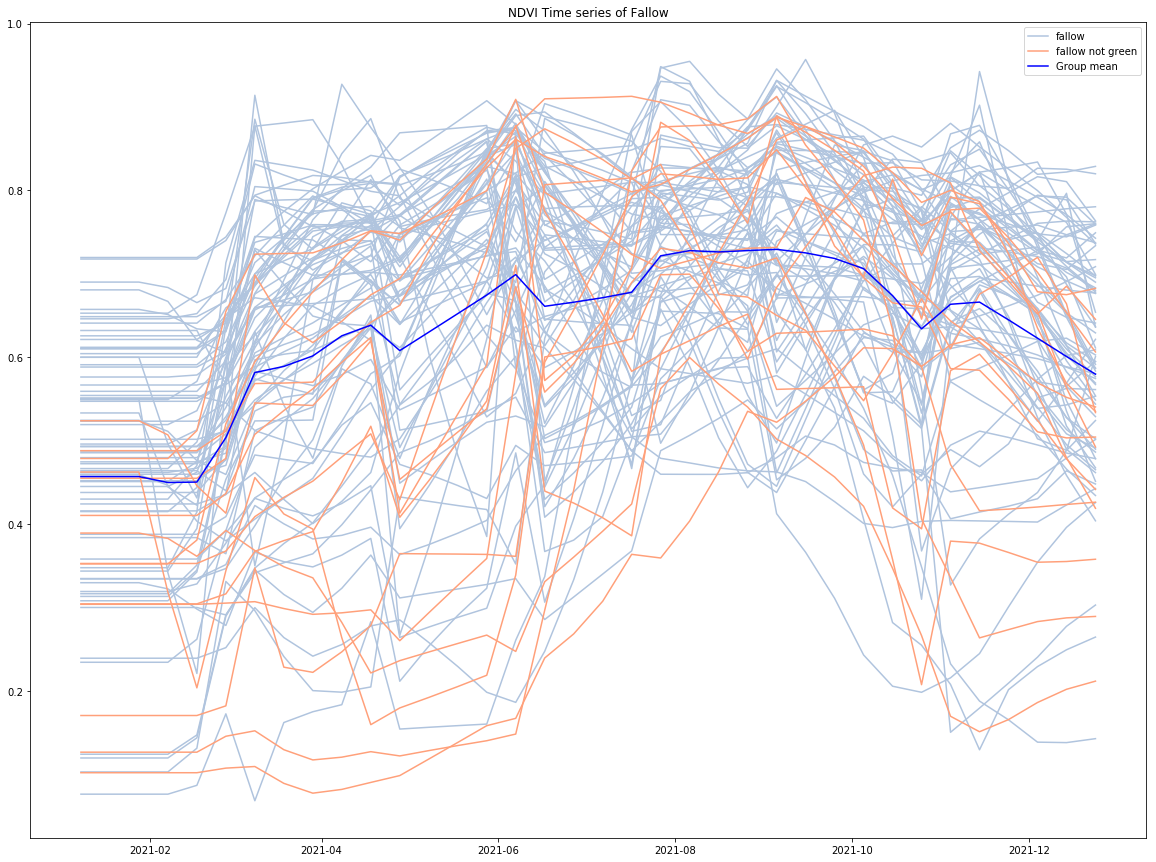

In [74]:
class_to_plot = 'Potato'

base = datetime.datetime(2021, 1, 8)
date_list = [base + datetime.timedelta(days=x) for x in range(0,360,10)]
fig, ax = plt.subplots(figsize=(20, 15), facecolor='white')

parcels_class = parcels_used[parcels_used['New_Group'] == class_to_plot]
index_class = parcels_class.index
ndvi_feat_class = ndvi_feat.loc[index_class]

cts = parcels_class['ct'].unique()
lines = []
# Plot each ct of the group with a different color
for i in range(len(cts)):
    index_ct = parcels_class[parcels_class['ct'] == cts[i]].index
    ndvi_feat_ct = ndvi_feat.loc[index_ct]

    for index, row in ndvi_feat_ct.iterrows():
        line_ct, = ax.plot(date_list,row, color_list[i], label=cts[i])
    lines.append(line_ct)


# Plot mean of Group
line_mean, = ax.plot(date_list, ndvi_feat_class.mean(), 'b')
lines.append(line_mean)
title = f'NDVI time series of {class_to_plot}'
plt.title(title)
cts_ll = list(cts)
cts_ll.append('Group mean')
plt.legend(lines, cts_ll)

# 3 - Classification - Random Forest

The classification step consists in one or many numerical processes to finally allocate every pixel or object to one of the classes of the land cover typology. The vast diversity of classification algorithms can be split into two main types: - the supervised type, which uses a training data set to calibrate the algorithm a priori; - and the unsupervised type, which produces clusters of pixels to be labelled a posteriori as land cover class in light of in situ or ancillary information.

Random Forest (RF), an improved implementation of Decision Trees (DT), is an ensemble-learning algorithm that combines multiple classifications of the same data to produce higher classification accuracies than other forms of DT. RF works by fitting many DT-based classifications to a data set, and then uses a rule-based approach to combine the predictions from all the trees. During this process, individual trees are grown from differing subsets of training data using a process called “bagging”. Bagging involves the random subsampling (with replacement) of the original data for growing each tree. Generally, for each tree grown, two thirds of the training data are used to grow the tree, while the remaining one third are left unused (out-of-bag, or OOB) for later error assessment. A classification is then fit to each bootstrap sample; however, at each node (split), only a small number of randomly selected predictor variables are used in the binary partitioning. The splitting process continues until further subdivision no longer reduces the Gini index. Each tree contributes to the assignment of the most frequent class to the input data with a single vote. The predicted class of an observation is calculated by the majority vote for that observation, with ties split randomly.

>**The random forest combines hundreds or thousands of decision trees, trains each one on a slightly different set of the observations, splitting nodes in each tree considering a limited number of the features. The final predictions of the random forest are made by averaging the predictions of each individual tree.**

[Watch this video if Decision Trees are not clear for you !](https://www.youtube.com/watch?v=7VeUPuFGJHk)

[Watch this video if Random Forest are not clear for you !](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)

In this section we will see how to use the Random Forest implementation provided by the scikit-learn library. Scikit-learn is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is its real strength.


## 3.1 - Create a training (or calibration) dataset and test (or validation) dataset

Split 50% train, 50% test (By class)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, parcels_used['New_Group'], test_size=0.5, random_state=42, stratify=parcels_used['New_Group'])

Plot the test dataset

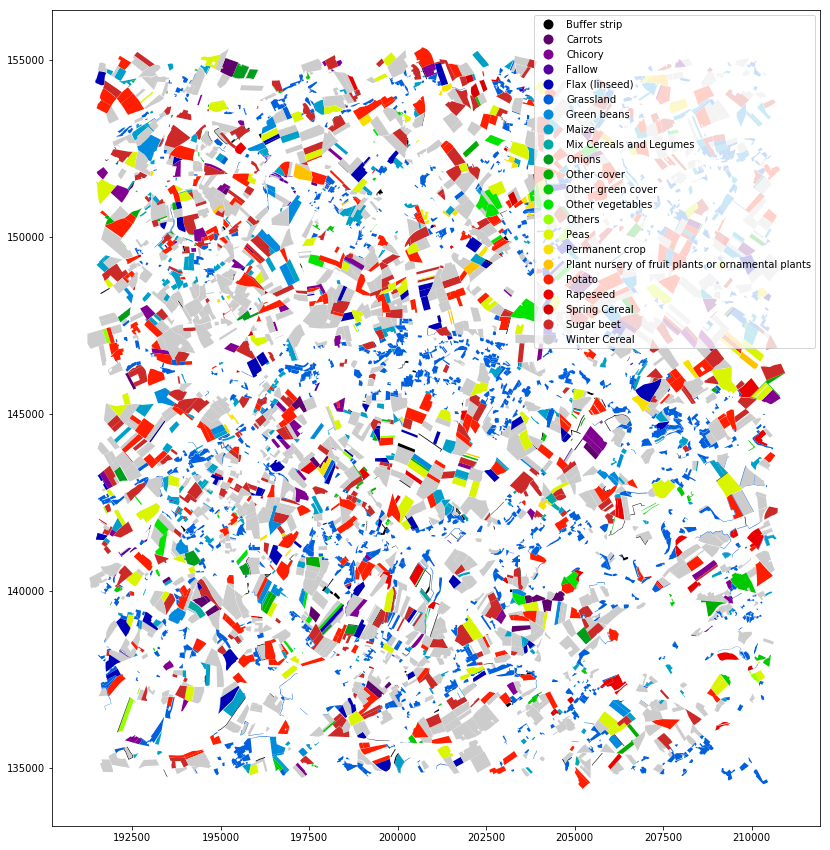

In [35]:
parcels_test = parcels_used.loc[y_test.index]
fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
parcels_test.plot(ax=ax, column='New_Group', legend=True, cmap = cm.get_cmap('nipy_spectral', 26))

## 3.2 - Random Forest Classifier

Train a Random Forest on the train set and use it to predict on the test set

In [36]:

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
predictions

array(['Winter Cereal', 'Sugar beet', 'Winter Cereal', ...,
       'Winter Cereal', 'Winter Cereal', 'Grassland'], dtype=object)

## 3.3 - Accuracy metrics

Analysis of the classification report :
- see the precision & recall
- from the precision and recall the F-1 gives a good overview of the performance for each crop type
- the support is the number of elements (here parcels) in each class

The results are summarized into the overall accuracy (OA), the macro average and the weighted average 

The confusion matrix allows to understand which classes are confunded with which classes

While the plot of the F1-score is a more confortable way to analysed the result by crop type


                                                    precision    recall  f1-score   support

                                      Buffer strip       0.56      0.41      0.47       140
                                           Carrots       0.90      0.79      0.84        34
                                           Chicory       0.91      0.94      0.93        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.81      0.97      0.88        91
                                         Grassland       0.87      0.98      0.92      1271
                                       Green beans       0.83      0.73      0.78        48
                                             Maize       0.93      0.96      0.94       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       1.00      0.67      0.

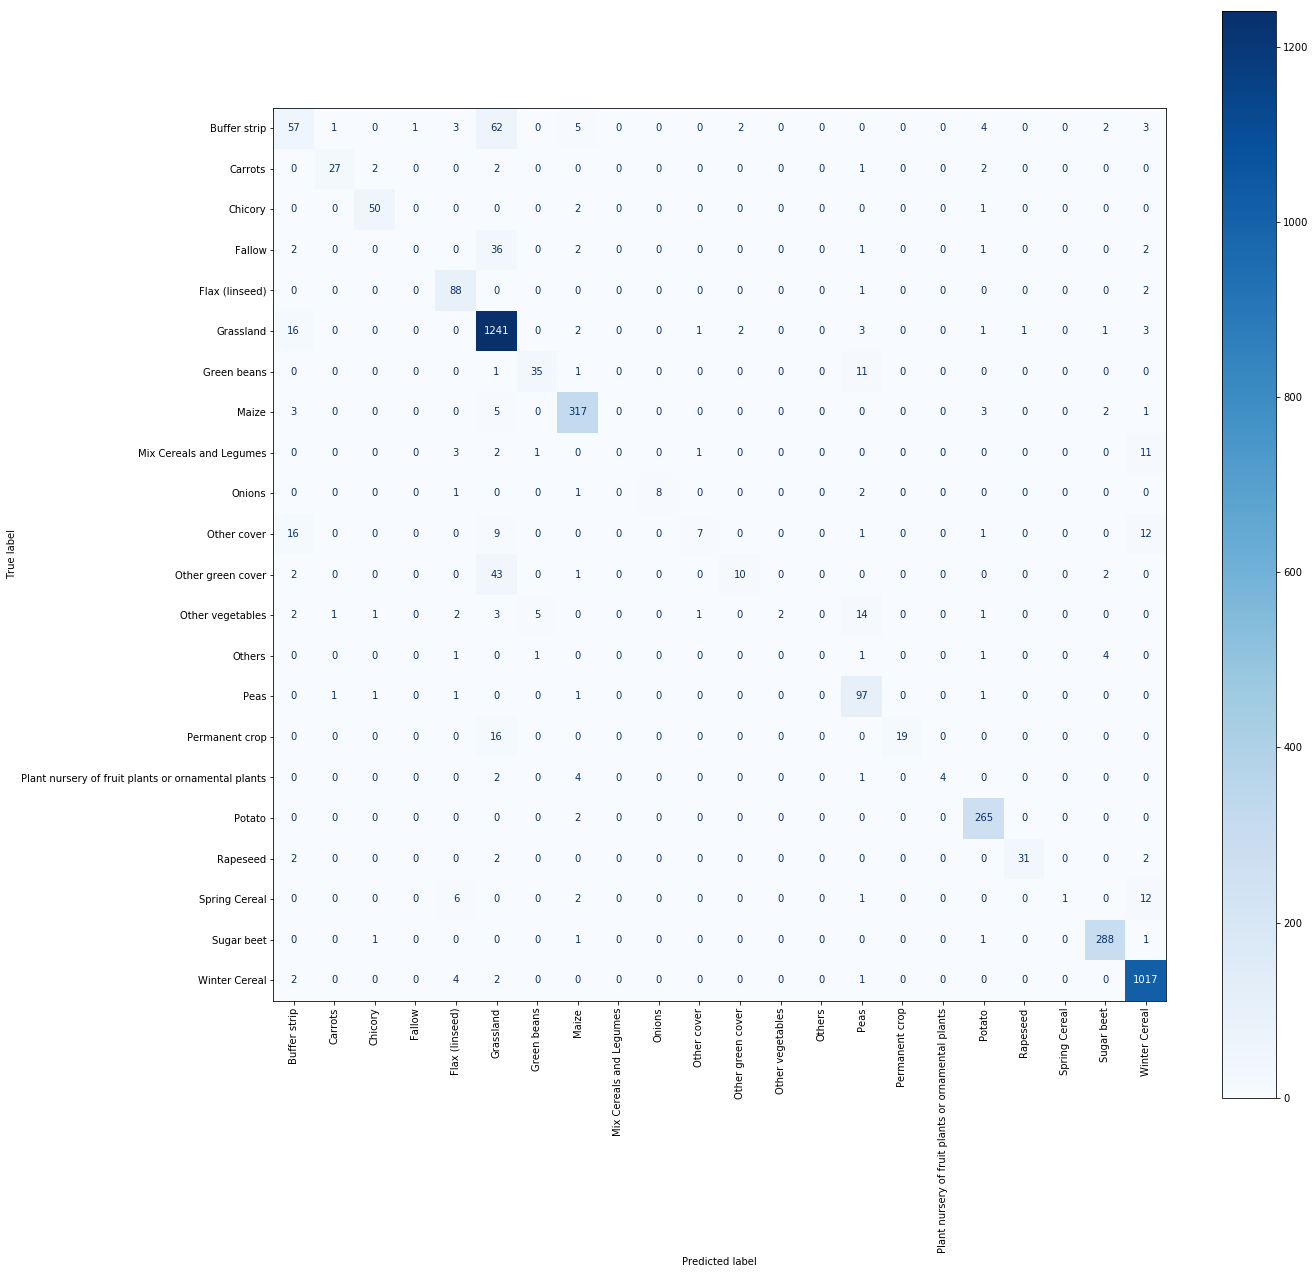

In [37]:
print(classification_report(y_test, predictions, zero_division=0))
fig, ax = plt.subplots(figsize=(20, 20), facecolor='white')
plot_confusion_matrix(clf, X_test, y_test, ax=ax, xticks_rotation=90, cmap='Blues')

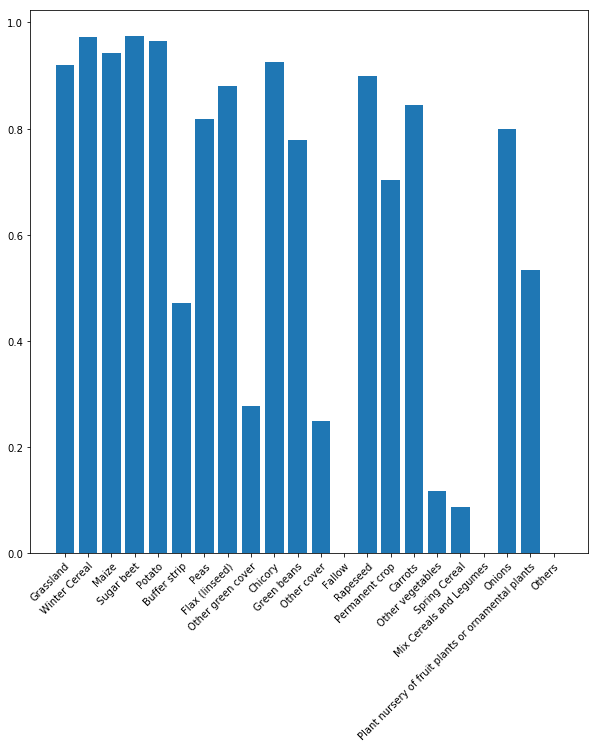

In [38]:
classif_report = classification_report(y_test, predictions, zero_division=0, output_dict=True)
plot_f1(classif_report)

Plot the predictions of the classifier

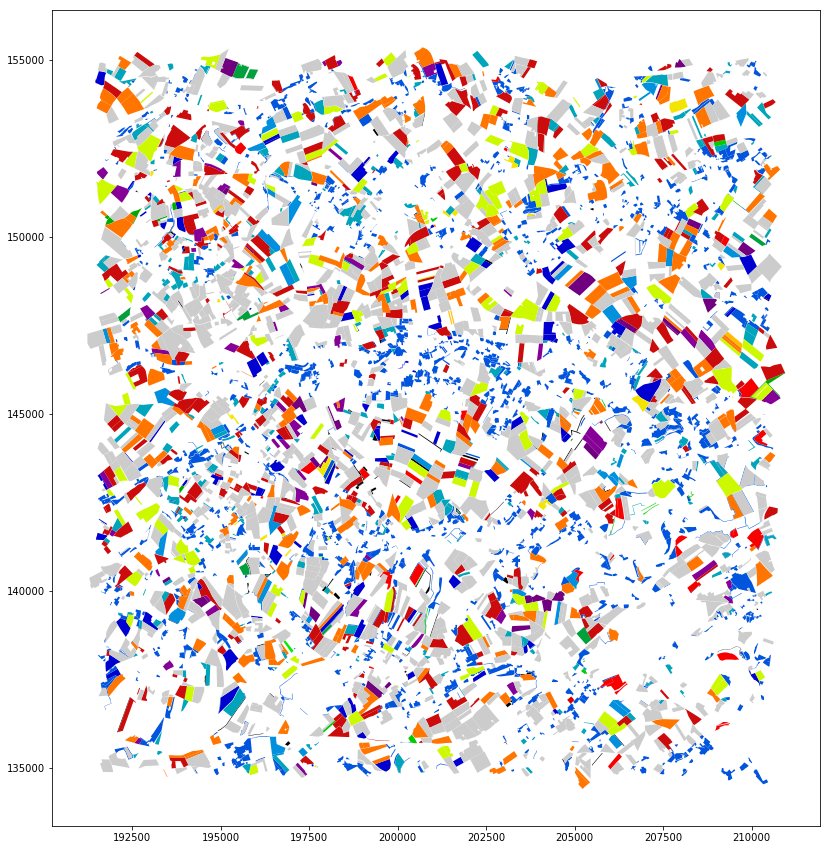

In [39]:
plot_preds(parcels_used, y_test, predictions)

# 4 - Selection of features from the Random Forest model

credits: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

## 4.1 - Run the RF model with the analysis of feature importance

The *selectFromModel* fonction looks for the features importance of the RF model and keep only those higher than a threshold (by default the threshold is the mean of all the feature importance)

In [40]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(random_state=42))

How many features are kept after selecting the most used features?

In [42]:
sel.fit(X_train, y_train)
sel_col = X_train.columns[(sel.get_support())]
sel_col

Index(['XX_2021_02_27_s2_mean_b4', 'XX_2021_02_27_s2_mean_b8',
       'XX_2021_02_27_s2_mean_ndvi', 'XX_2021_03_09_s2_mean_ndvi',
       'XX_2021_03_19_s2_mean_b3', 'XX_2021_03_19_s2_mean_b4',
       'XX_2021_03_19_s2_mean_ndwi', 'XX_2021_03_29_s2_mean_b3',
       'XX_2021_03_29_s2_mean_b4', 'XX_2021_03_29_s2_mean_ndvi',
       ...
       'XX_2021_10_15_s2_mean_b8', 'XX_2021_10_25_s2_mean_ndvi',
       'XX_2021_11_04_s2_mean_ndvi', 'XX_2021_11_14_s2_mean_ndvi',
       'XX_2021_11_24_s2_mean_ndvi', 'XX_2021_12_04_s2_mean_ndvi',
       'XX_2021_12_04_s2_mean_ndwi', 'XX_2021_12_14_s2_mean_ndvi',
       'XX_2021_12_14_s2_mean_ndwi', 'XX_2021_12_24_s2_mean_ndwi'],
      dtype='object', length=125)

## 4.2 - Impact of the selection of features on the accuracy

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.57      0.39      0.46       140
                                           Carrots       0.90      0.76      0.83        34
                                           Chicory       0.93      0.94      0.93        53
                                            Fallow       1.00      0.02      0.04        44
                                    Flax (linseed)       0.81      0.97      0.88        91
                                         Grassland       0.87      0.98      0.92      1271
                                       Green beans       0.77      0.77      0.77        48
                                             Maize       0.92      0.96      0.94       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       0.88      0.58      0.

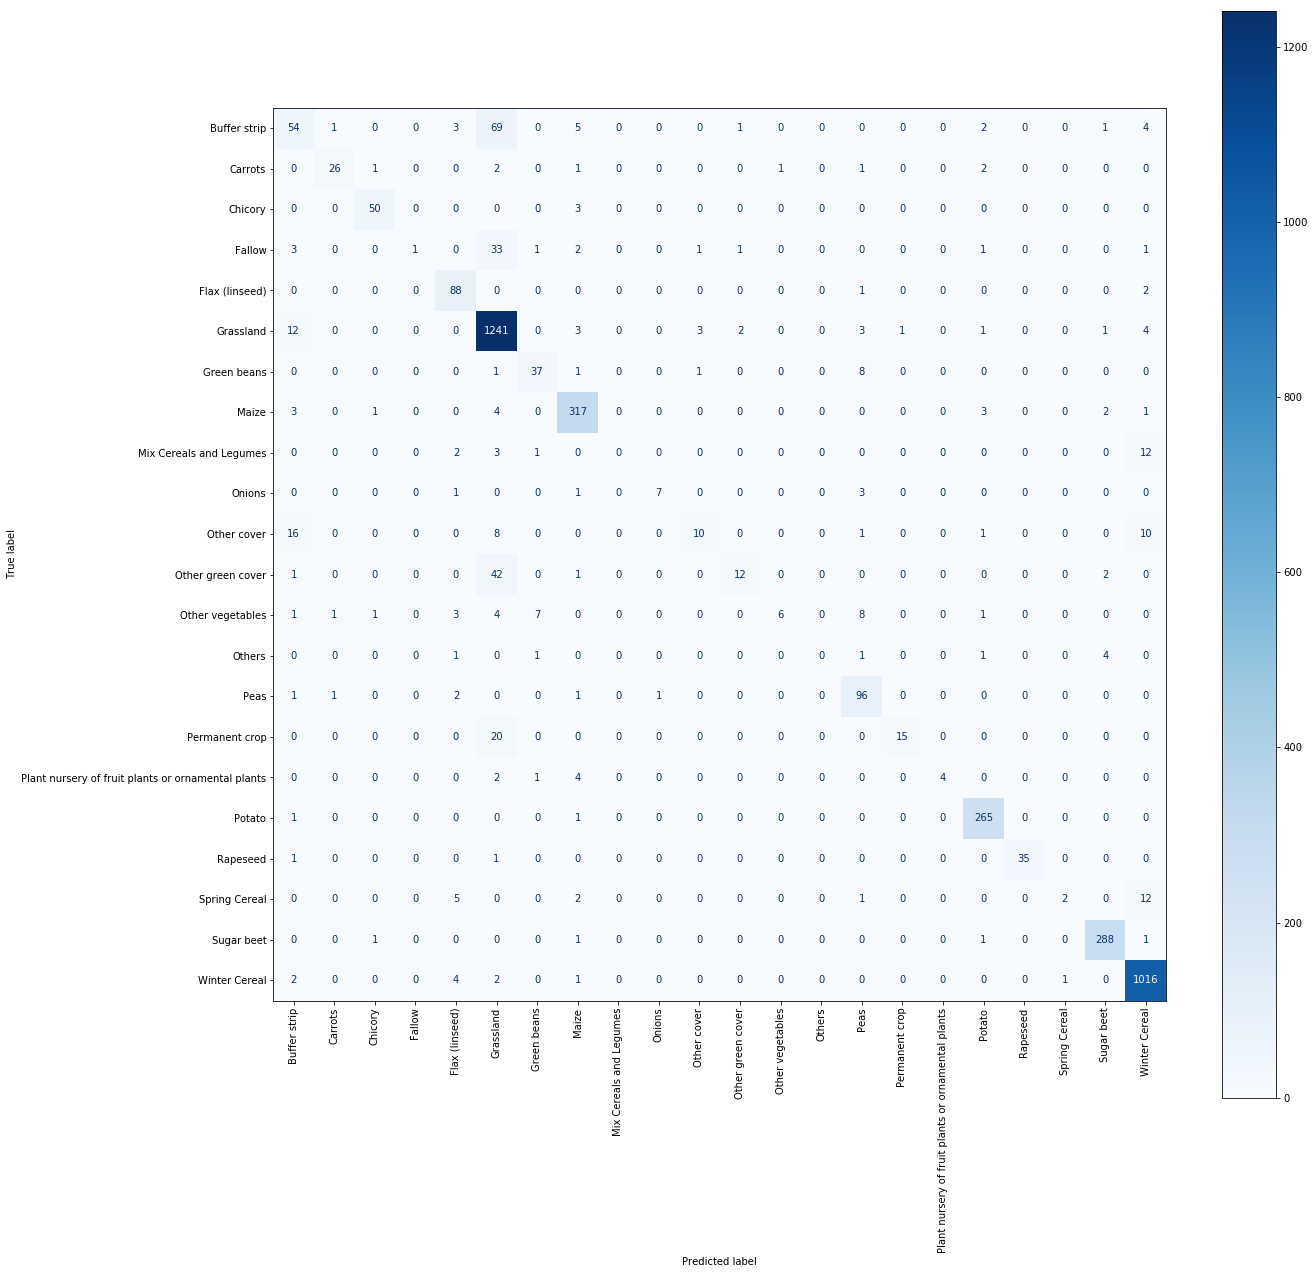

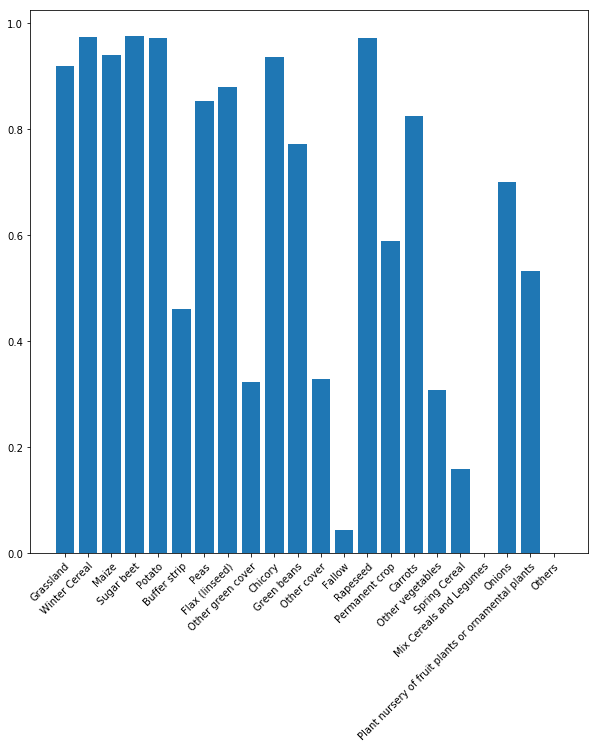

In [43]:
X_train_sel = X_train[sel_col]
X_test_sel = X_test[sel_col]
show_results_RF(X_train_sel, y_train, X_test_sel, y_test)

The selection of features allows to reduce the preprocessing costs while preserving a similar accuracy and robustness (often slightly better)

## 4.3 - Which features are used ?

In [44]:
sel_arr = sel.get_support()
sel_arr.shape
n_dates = 36
n_feats = int(sel_arr.shape[0]/(n_dates*2))
sel_arr = sel_arr.reshape((2,n_dates,n_feats)) #[mean/dev, dates, features]
print(sel_arr.shape)
feats = []
for coli in X_train.columns[:7]:
    feats.append(coli[14:])
for coli in X_train.columns[-7:]:
    feats.append(coli[14:])
feats

(2, 36, 7)


['s2_mean_b3',
 's2_mean_b4',
 's2_mean_b8',
 's2_mean_b11',
 's2_mean_ndvi',
 's2_mean_ndwi',
 's2_mean_brightness',
 's2_dev_b3',
 's2_dev_b4',
 's2_dev_b8',
 's2_dev_b11',
 's2_dev_ndvi',
 's2_dev_ndwi',
 's2_dev_brightness']

### 4.3.1 - Importance of features per dates

>The standard deviation are never used, it's not relevant to used it in this type of classification

In [45]:
base = datetime.datetime(2021, 1, 8)
date_list = [base + datetime.timedelta(days=x) for x in range(0,360,10)]
# See number of important date by feature
pd.DataFrame(data = {'number of important dates':sel_arr.sum(axis=1).reshape((n_feats*2))}, index=feats)
# In this case, the dev features are never used

number of important dates
s2_mean_b3                                 19
s2_mean_b4                                 20
s2_mean_b8                                 14
s2_mean_b11                                14
s2_mean_ndvi                               28
s2_mean_ndwi                               24
s2_mean_brightness                          6
s2_dev_b3                                   0
s2_dev_b4                                   0
s2_dev_b8                                   0
s2_dev_b11                                  0
s2_dev_ndvi                                 0
s2_dev_ndwi                                 0
s2_dev_brightness                           0

### 4.3.2 Importance of dates per features

Text(0,0.5,'number of important features')

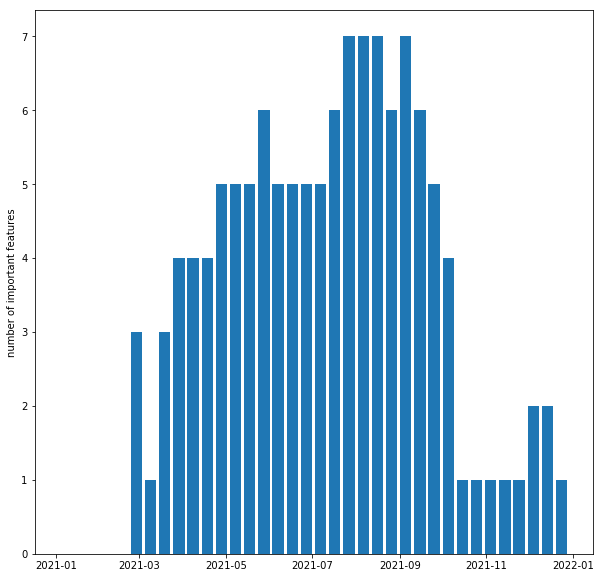

In [46]:
# See number of important features by date
# See number of important features by date
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax.bar(date_list, sel_arr.sum(axis=0).sum(axis=1), width=8.0)
plt.ylabel('number of important features')

See number of dates that has to be preprocessed
>In this case, 5 dates are irrelevant for the random classification

In [47]:
np.count_nonzero(sel_arr.sum(axis=0).sum(axis=1))

31

# 5 - Take a maximum number of samples per class

## 5.1 - See how much elements are in each class
 (number of parcels per crop type/group)

In [48]:
y_train.value_counts()

Grassland                                             1271
Winter Cereal                                         1025
Maize                                                  330
Sugar beet                                             293
Potato                                                 267
Buffer strip                                           140
Peas                                                   102
Flax (linseed)                                          92
Other green cover                                       59
Chicory                                                 52
Green beans                                             48
Other cover                                             46
Fallow                                                  44
Rapeseed                                                37
Permanent crop                                          35
Carrots                                                 35
Other vegetables                                        

## 5.2 - What would be the impact of taking a maximum number of samples per class ? 

>The n_max_samples suggested here is 100

In [49]:
train_max_ids = []
n_max_samples = 100

In [50]:
for label in clf.classes_:
    y_train_label = y_train[y_train == label]
    if len(y_train_label) < n_max_samples:
        ids_label = y_train_label.index
    else:
        sampled = y_train_label.sample(n=n_max_samples,random_state=42)
        ids_label = sampled.index
    
    train_max_ids.extend(ids_label)

In [51]:
X_train_max = X_train.loc[train_max_ids]
y_train_max = y_train.loc[train_max_ids]

## 5.3 - RF + Metrics

### 5.3.1 - Impact of taking a maximum number of each class on the accuracy metrics

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.30      0.73      0.42       140
                                           Carrots       0.87      0.76      0.81        34
                                           Chicory       0.88      0.94      0.91        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.77      0.97      0.86        91
                                         Grassland       0.96      0.79      0.87      1271
                                       Green beans       0.70      0.62      0.66        48
                                             Maize       0.94      0.96      0.95       331
                           Mix Cereals and Legumes       0.50      0.11      0.18        18
                                            Onions       0.88      0.58      0.

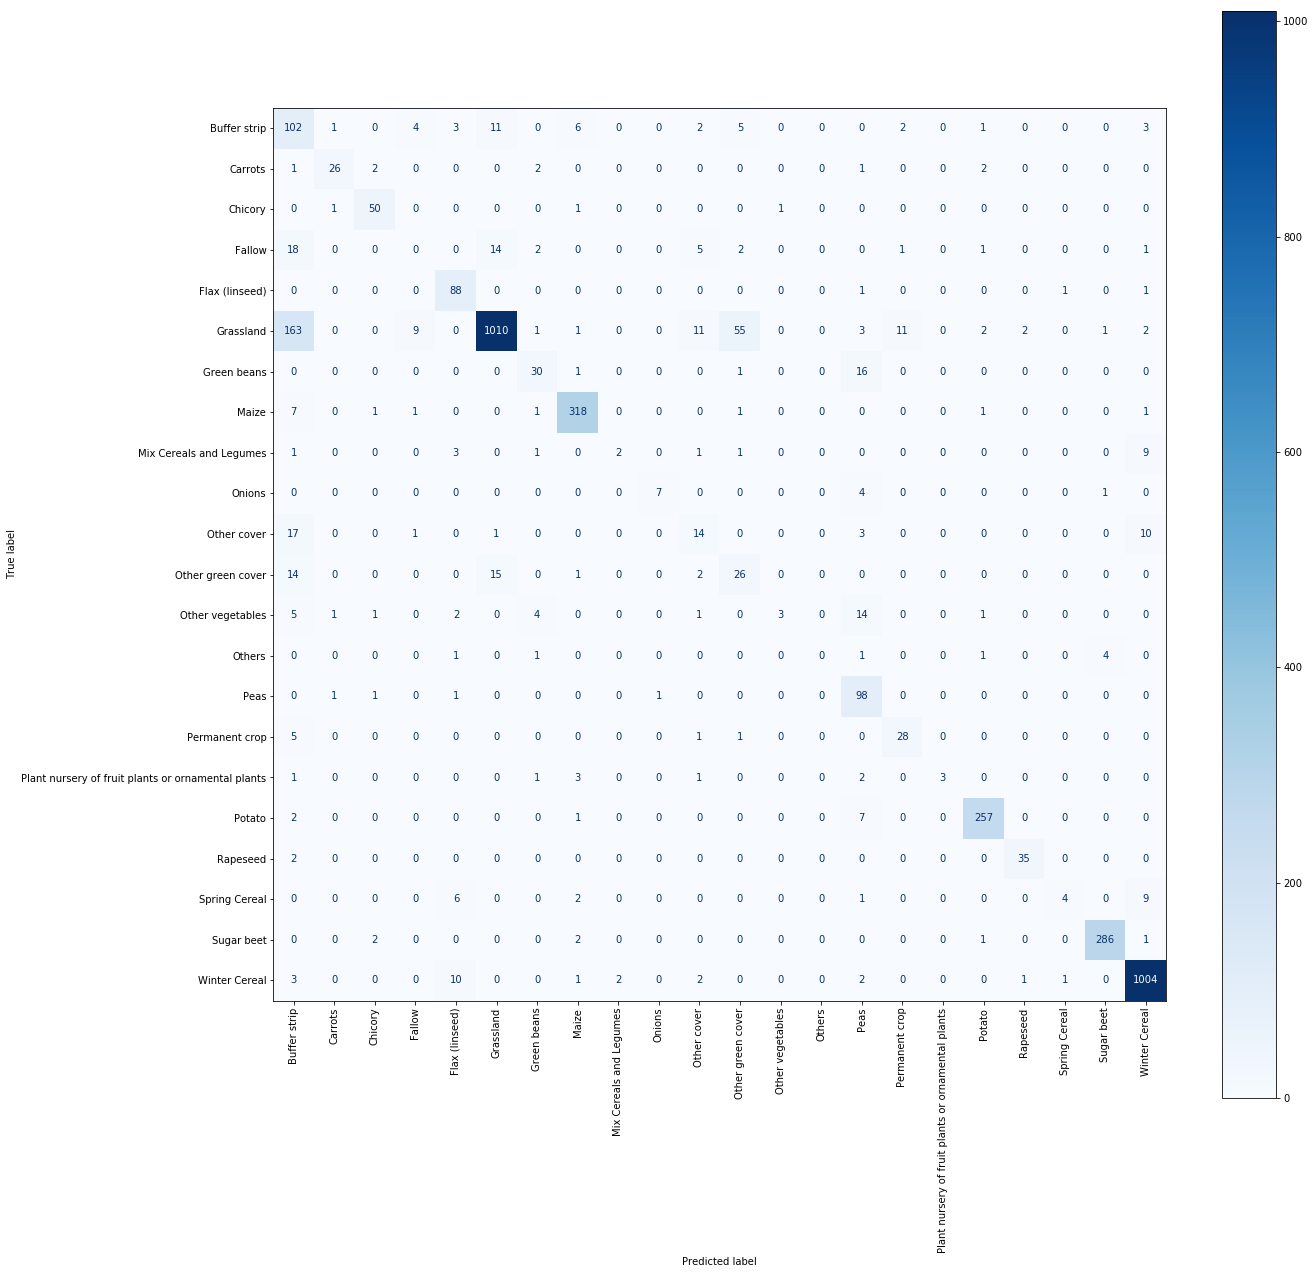

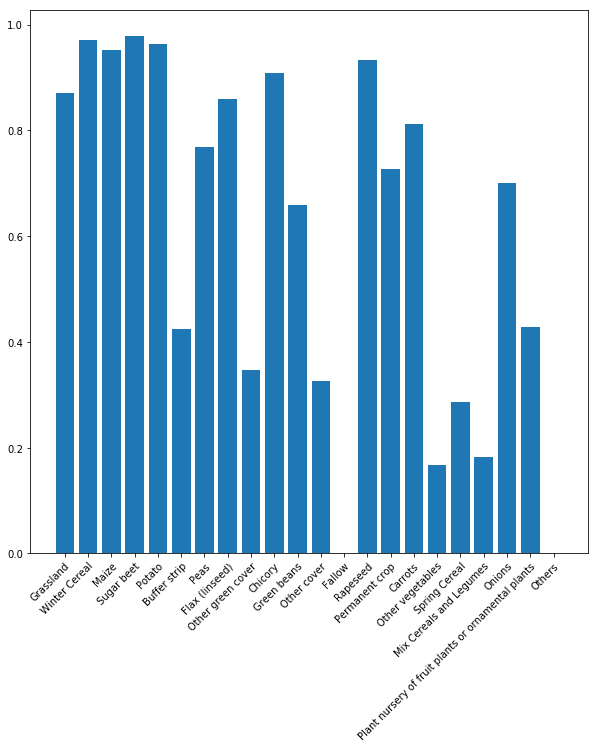

In [52]:
show_results_RF(X_train_max, y_train_max, X_test, y_test)

# 6 - Custom Sampling Design

## 6.1 - See how much elements are in each class

In [53]:
y_train.value_counts()

Grassland                                             1271
Winter Cereal                                         1025
Maize                                                  330
Sugar beet                                             293
Potato                                                 267
Buffer strip                                           140
Peas                                                   102
Flax (linseed)                                          92
Other green cover                                       59
Chicory                                                 52
Green beans                                             48
Other cover                                             46
Fallow                                                  44
Rapeseed                                                37
Permanent crop                                          35
Carrots                                                 35
Other vegetables                                        

In order to have a more consistant training dataset, we balanced the number of parcels in each class. 
- If the total number of parcel in the class is under the *low threshold*, all the parcels of the training dataset are used
- If the total number of parcel in the class is above the *high threshodl*, 50% of the parcels of the training dataset are used
- If the total number of parcel in the class is between the *low threshold* and the *high threshold*, 75% of the parcels are training dataset are used

In [54]:
train_custom_ids = []
high_threshold = 400
low_threshold = 100

In [55]:
for label in clf.classes_:
    y_train_label = y_train[y_train == label]
    if len(y_train_label) < low_threshold:
        # Take all
        ids_label = y_train_label.index
    elif len(y_train_label) > high_threshold:
        # Take minimum between 50% and high_threshold
        n_samples = int(min(high_threshold, len(y_train_label)*0.5))
        sampled = y_train_label.sample(n=n_samples, random_state=42)
        ids_label = sampled.index
    else:
        # Take 75%
        n_samples = int(len(y_train_label)*0.75)
        sampled = y_train_label.sample(n=n_samples,random_state=42)
        ids_label = sampled.index
    
    train_custom_ids.extend(ids_label)

In [56]:
X_train_custom = X_train.loc[train_custom_ids]
y_train_custom = y_train.loc[train_custom_ids]

Let's see how many parcels are in each class now

In [57]:
y_train_custom.value_counts()

Grassland                                             400
Winter Cereal                                         400
Maize                                                 247
Sugar beet                                            219
Potato                                                200
Buffer strip                                          105
Flax (linseed)                                         92
Peas                                                   76
Other green cover                                      59
Chicory                                                52
Green beans                                            48
Other cover                                            46
Fallow                                                 44
Rapeseed                                               37
Carrots                                                35
Permanent crop                                         35
Other vegetables                                       31
Spring Cereal 

## 6.2. - RF + Metrics

How did it impact the accuracy of the Random Forest ?

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.43      0.49      0.46       140
                                           Carrots       0.84      0.79      0.82        34
                                           Chicory       0.94      0.94      0.94        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.75      0.97      0.84        91
                                         Grassland       0.90      0.94      0.92      1271
                                       Green beans       0.79      0.79      0.79        48
                                             Maize       0.92      0.95      0.94       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       0.88      0.58      0.

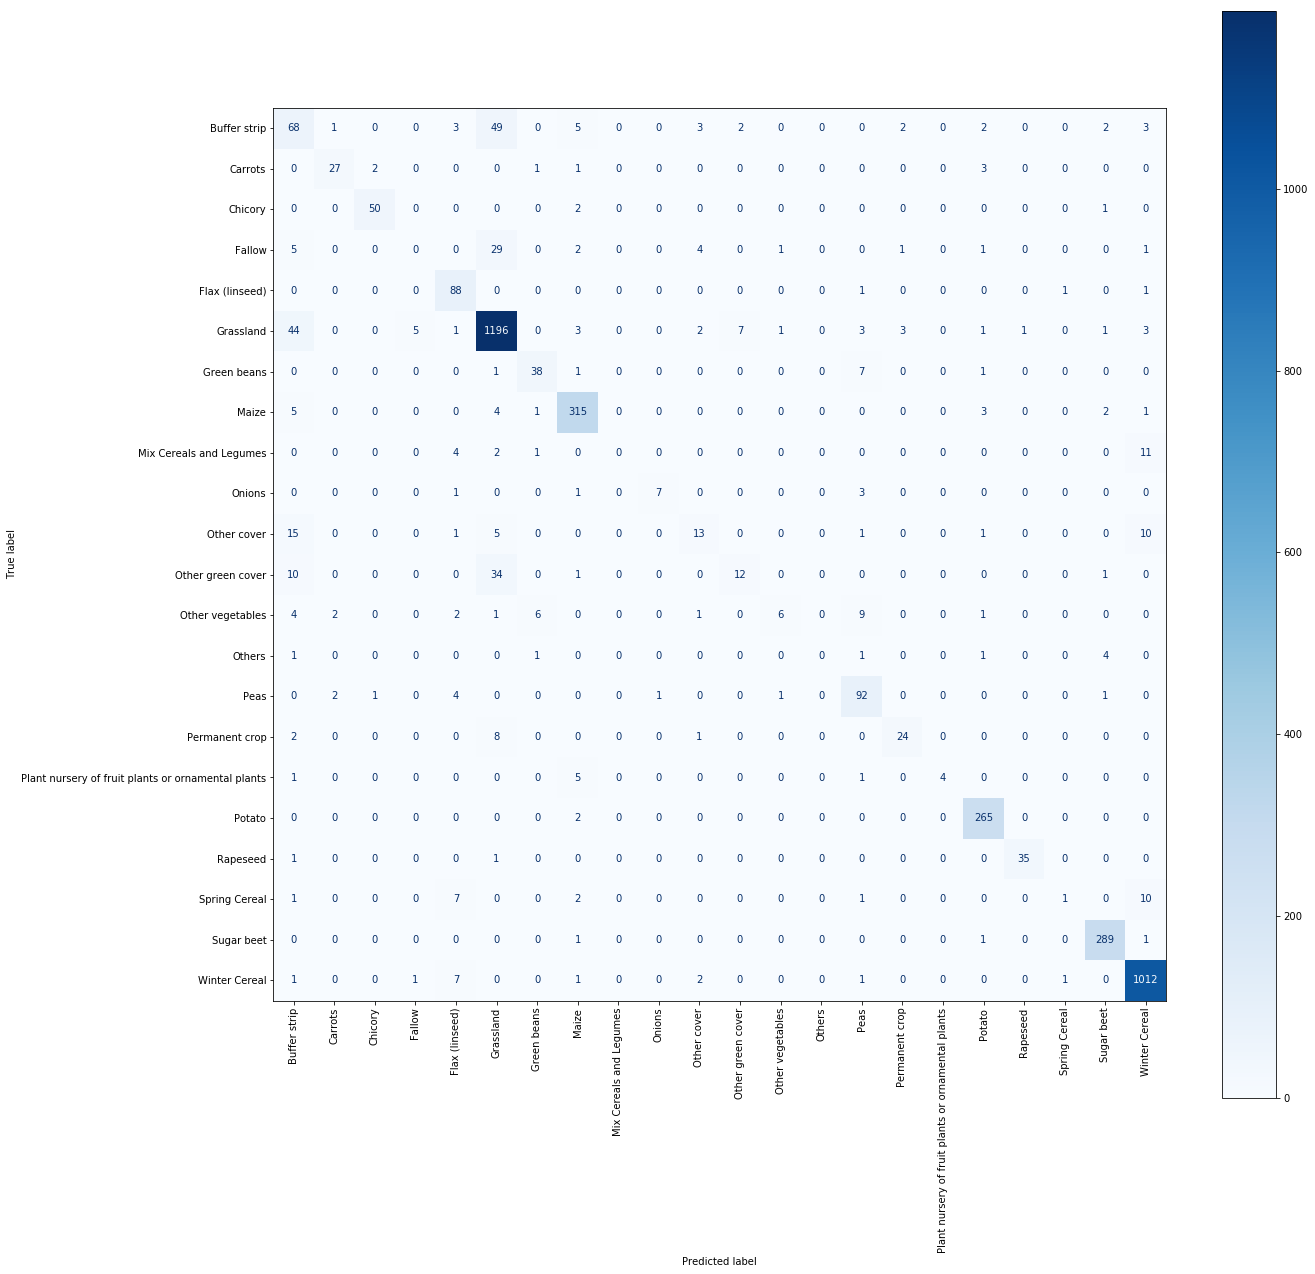

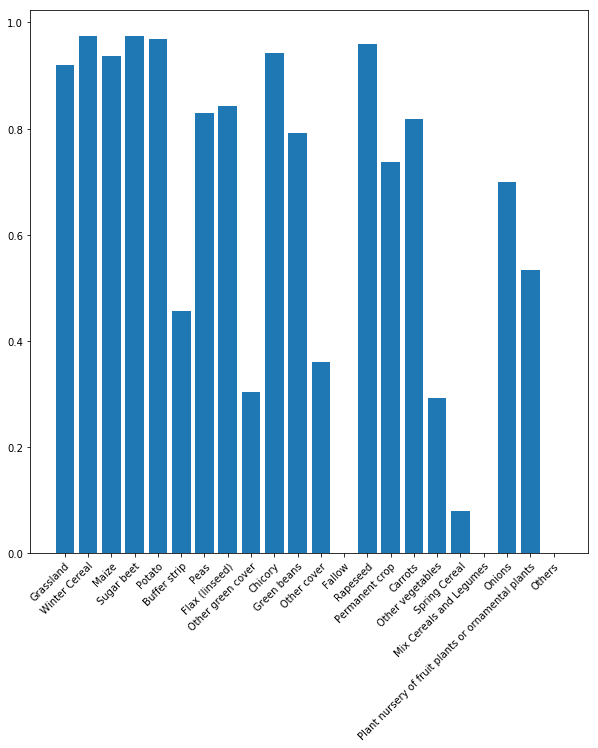

In [58]:
show_results_RF(X_train_custom, y_train_custom, X_test, y_test)

# 7 - Without Grassland

## 7.1 - Remove Grassland from Training dataset

Get ids of non Grassland in y_train and y_test

In [59]:
non_grasslands_train_ids = y_train[y_train != 'Grassland'].index
non_grasslands_test_ids = y_test[y_test != 'Grassland'].index

Keep only non grassland

In [60]:
y_train_non_G = y_train.loc[non_grasslands_train_ids]
X_train_non_G = X_train.loc[non_grasslands_train_ids]
y_test_non_G = y_test.loc[non_grasslands_test_ids]
X_test_non_G = X_test.loc[non_grasslands_test_ids]

## 7.2 - RF + Metrics

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.55      0.79      0.65       140
                                           Carrots       0.90      0.79      0.84        34
                                           Chicory       0.96      0.96      0.96        53
                                            Fallow       0.67      0.05      0.09        44
                                    Flax (linseed)       0.82      0.96      0.88        91
                                       Green beans       0.76      0.65      0.70        48
                                             Maize       0.92      0.96      0.94       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       1.00      0.67      0.80        12
                                       Other cover       0.82      0.20      0.

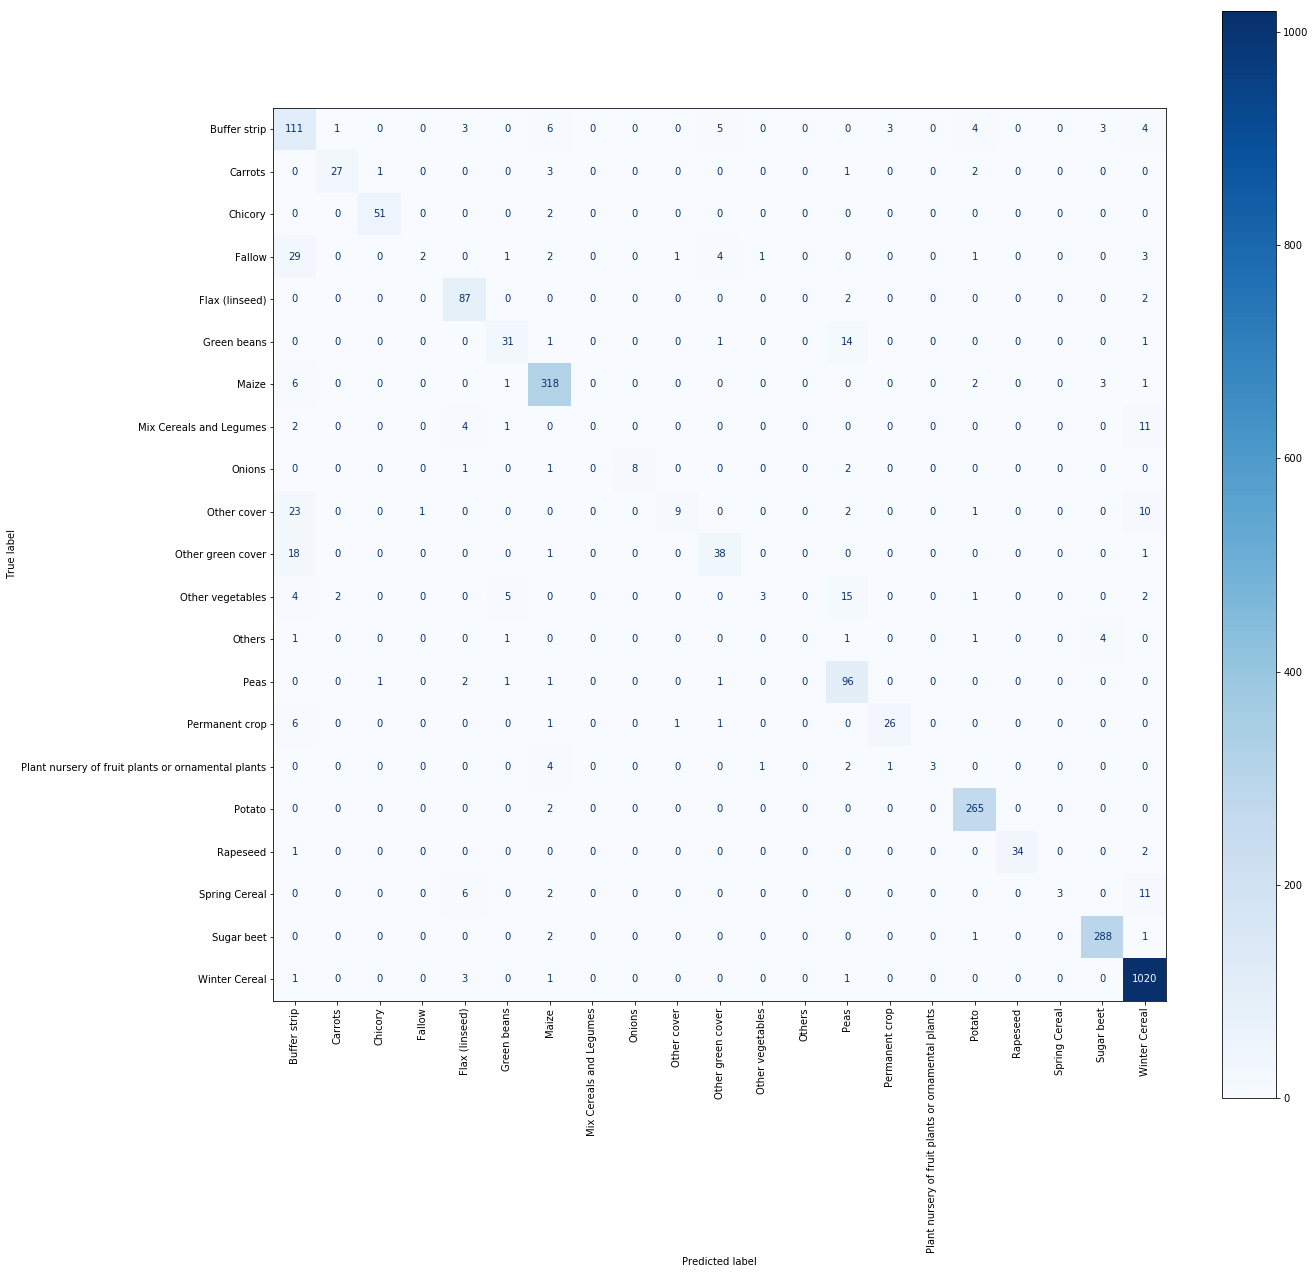

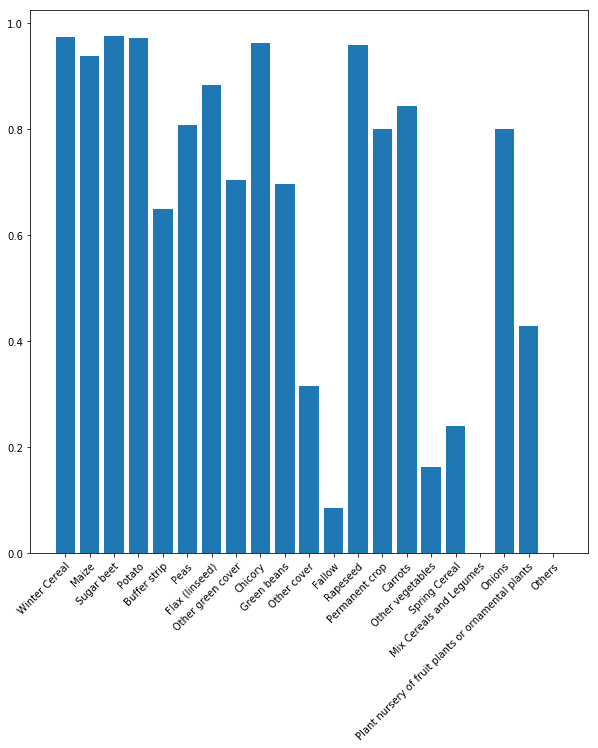

In [61]:
show_results_RF(X_train_non_G, y_train_non_G, X_test_non_G, y_test_non_G)

# 8 - Tuning RF's hyperparameters

While the default values of the Random Forest classifier are often a good start, it is possible that some other values can produce significant improvements to the model's accuracy. Of course, checking all the possible values for all the parameters is very costly. The GridSearchCV allows to try some parameters and to validate their performance with cross validation. The parameters can be iteratively improved by doing several grid searches and defining a finer grid after each iteration.

## 8.1 - Finding better parameter values with a Grid Search

In [62]:
from sklearn.model_selection import GridSearchCV

In this example, only few parameters are explored to keep the computation time relatively low. The parameters are the following :
- *n_estimators* : the number of trees in the forest. (default is 100)
- *criterion* : The function to measure the quality of a split. (default is 'gini')
- *max_depth* : The maximum depth of the tree. (default is None)

In [63]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[8,10,12,None], 'n_estimators':[50,100,200]}
rf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rf, parameters, cv=3)
clf.fit(X_train, y_train)


sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

The estimated accuracy of each set of parameters are printed

In [64]:
for i in range(len(clf.cv_results_['params'])):
    print(clf.cv_results_['params'][i])
    print(clf.cv_results_['mean_test_score'][i])
    print()

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 50}
0.8682755153343389

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}
0.8657616892911011

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200}
0.8672699849170438

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
0.8707893413775767

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.8717948717948718

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
0.8720462543991956

{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 50}
0.8717948717948718

{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100}
0.8755656108597285

{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 200}
0.875062845651081

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}
0.8712921065862242

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.8730517848164907

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
0.8748114630467572

{'criterion': 'entropy', 'max_depth': 8, '

The best set of parameters can be obtained with best_params_ 

In [65]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}

## 8.2 - Applying the best set of parameters found

Let's see the impact of the grid search

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.57      0.33      0.42       140
                                           Carrots       0.89      0.74      0.81        34
                                           Chicory       0.93      0.94      0.93        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.83      0.96      0.89        91
                                         Grassland       0.86      0.98      0.92      1271
                                       Green beans       0.74      0.67      0.70        48
                                             Maize       0.91      0.95      0.93       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       1.00      0.58      0.

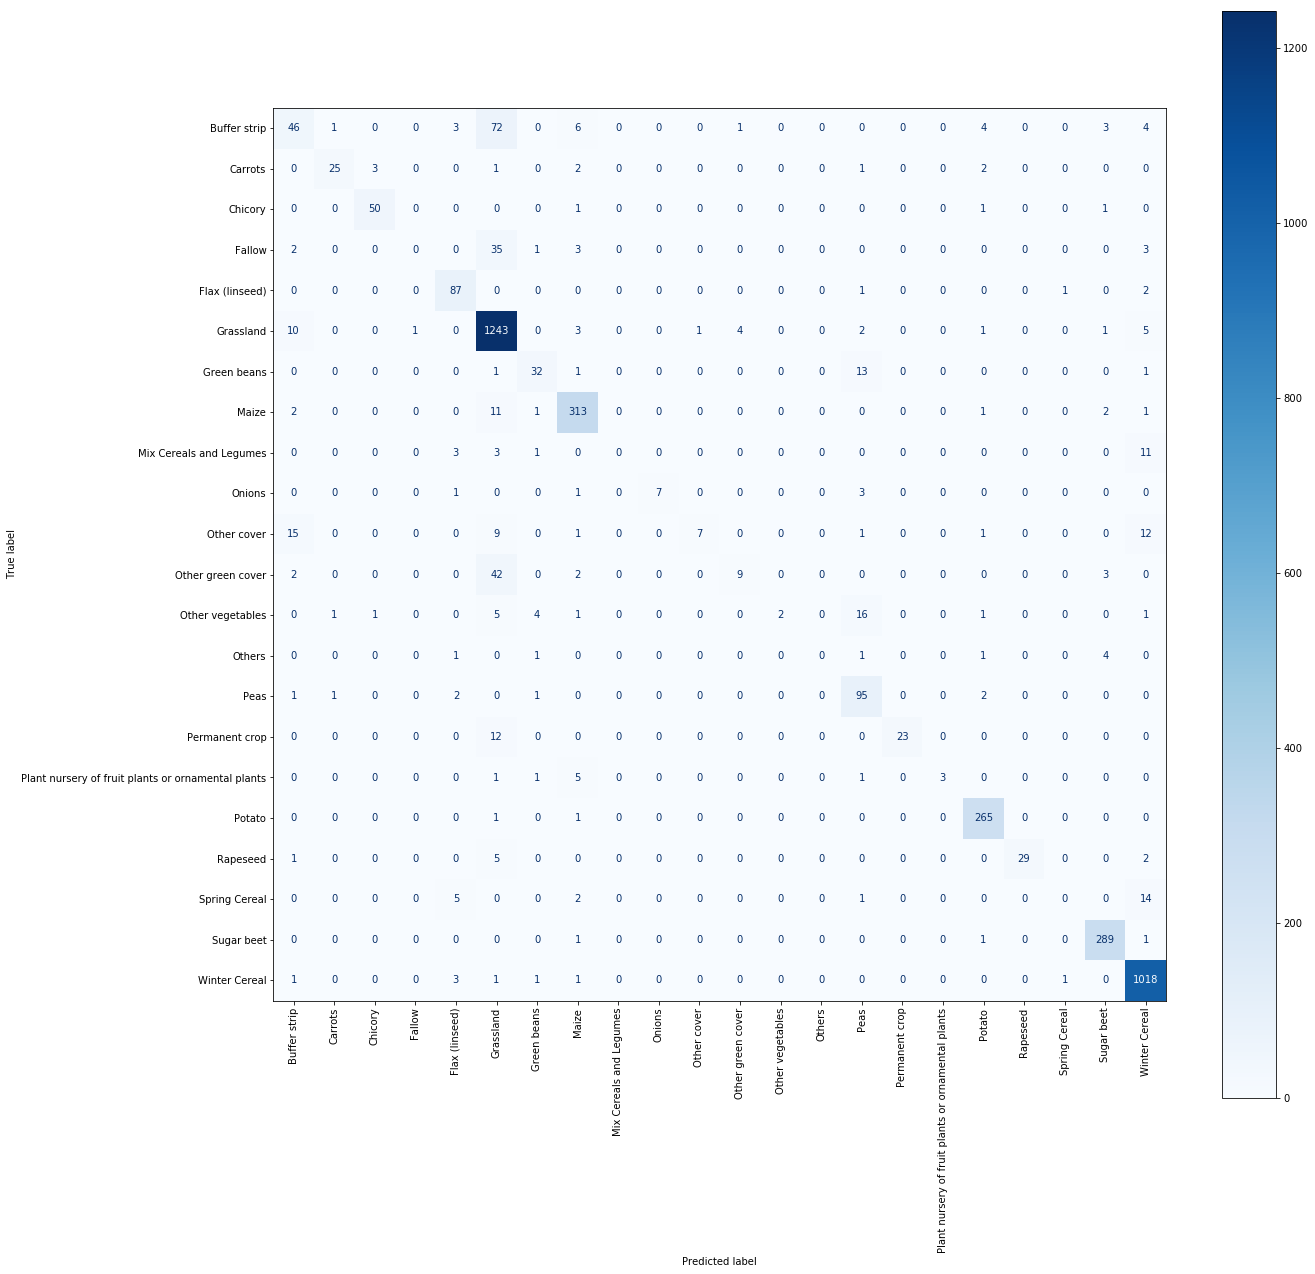

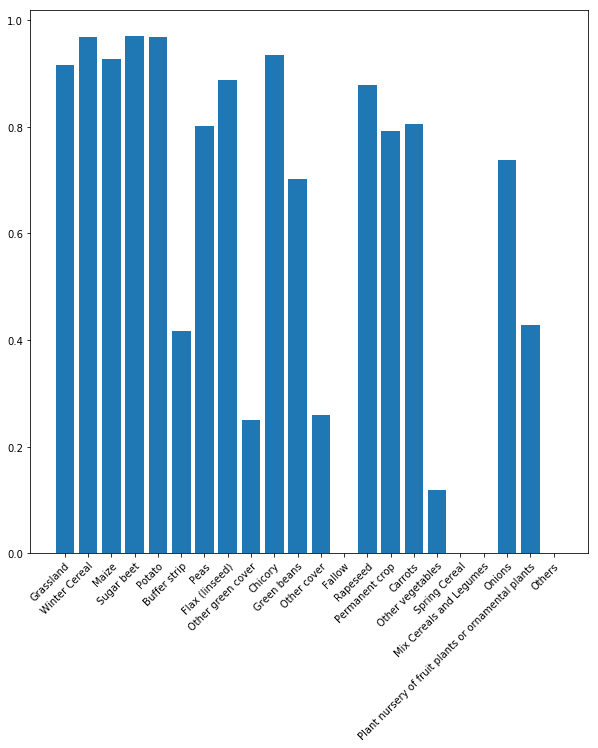

In [66]:
show_results(clf,X_test,y_test)

# 9 - Other Machine Learning Models

Choosing the best Machine Learning model is not often an easy task. The selection of the best model depends on several factor such as the computation resources, the distribution of the data, the amount of training data,...  

The advantages and disadvantages of all models are beyond the scope of this notebook but, if you have no idea where to start, you can take a look at this map : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In this section, several models are tested : LinearSVC, KNeighborsClassifier, SVC and MLPClassifier

In [67]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## 9.1 - LinearSVC

/export/miro/diheymans/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                                                    precision    recall  f1-score   support

                                      Buffer strip       0.12      0.95      0.21       140
                                           Carrots       0.93      0.41      0.57        34
                                           Chicory       0.88      0.70      0.78        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.93      0.84      0.88        91
                                         Grassland       0.98      0.55      0.70      1271
                                       Green beans       0.41      0.83      0.55        48
                                             Maize       0.98      0.73      0.84       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       0.83      0.42      0.

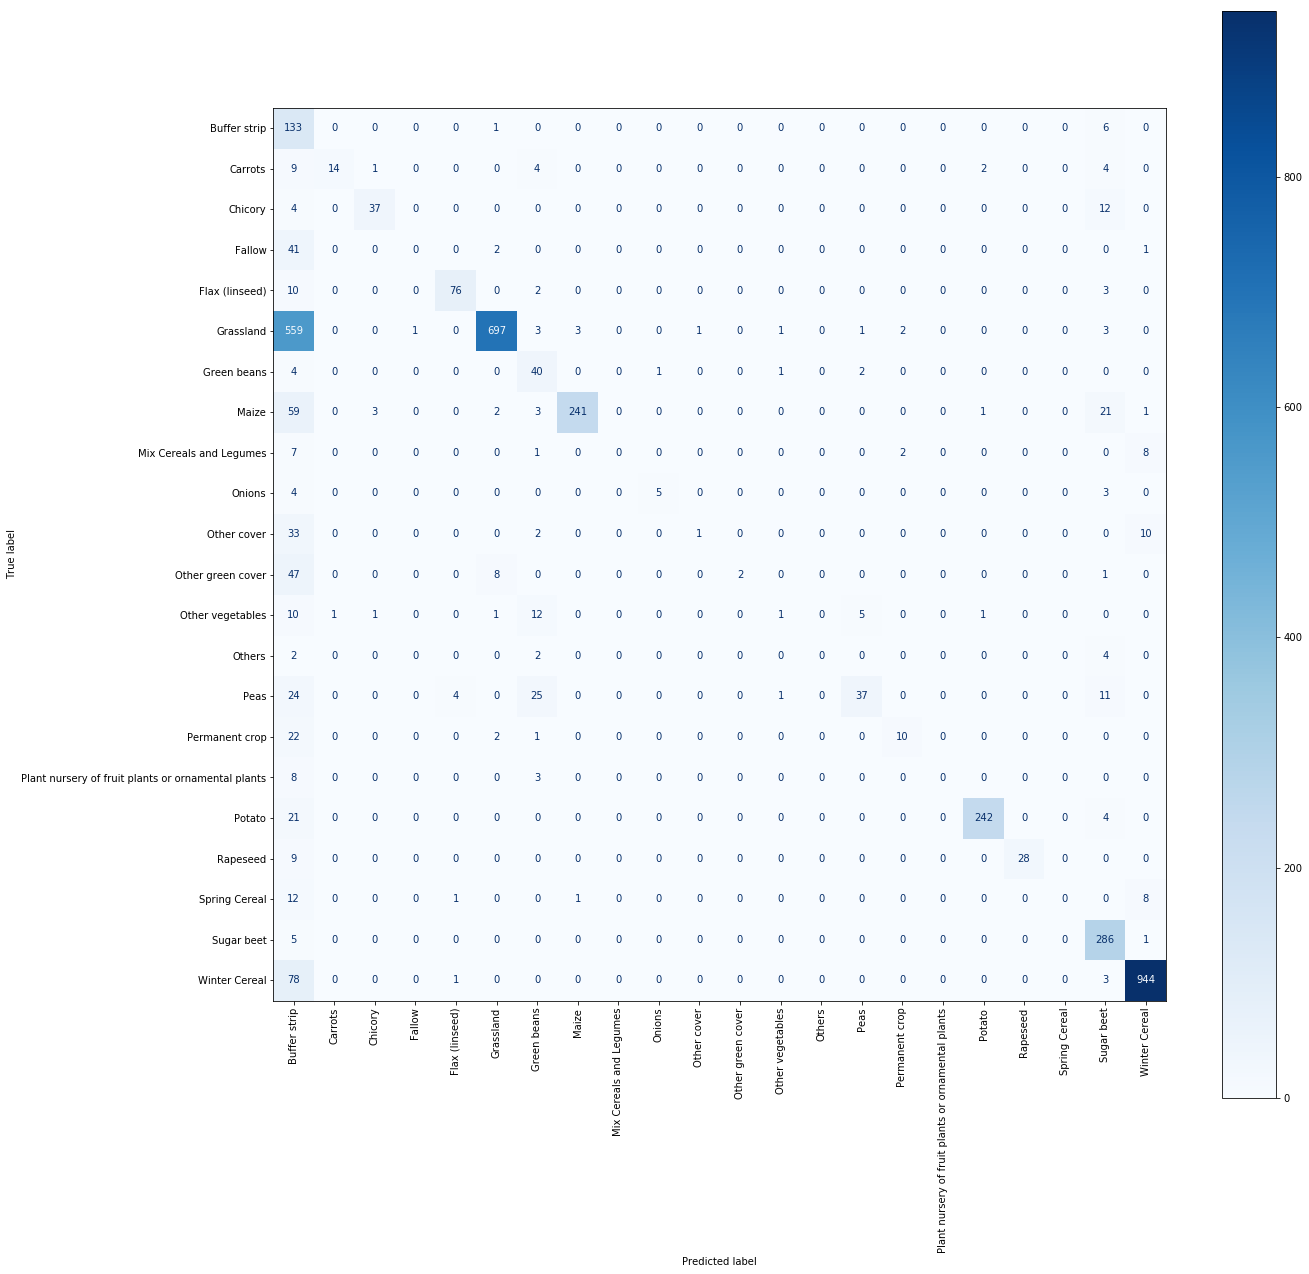

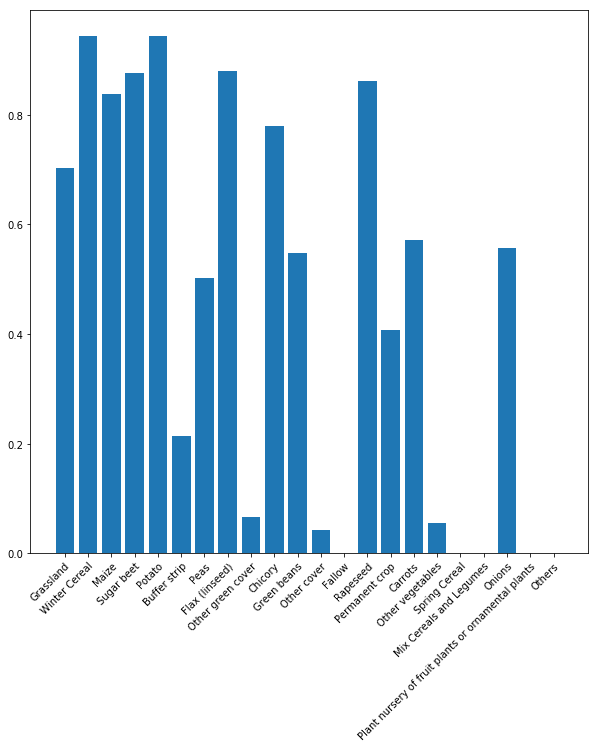

In [68]:
clf_LSVC = LinearSVC(random_state=42)
clf_LSVC.fit(X_train, y_train)
show_results(clf_LSVC, X_test, y_test)

## 9.2 - KNeighborsClassifier

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.48      0.37      0.42       140
                                           Carrots       0.69      0.53      0.60        34
                                           Chicory       0.72      0.49      0.58        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.66      0.89      0.76        91
                                         Grassland       0.87      0.95      0.91      1271
                                       Green beans       0.61      0.40      0.48        48
                                             Maize       0.83      0.90      0.87       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       0.67      0.33      0.

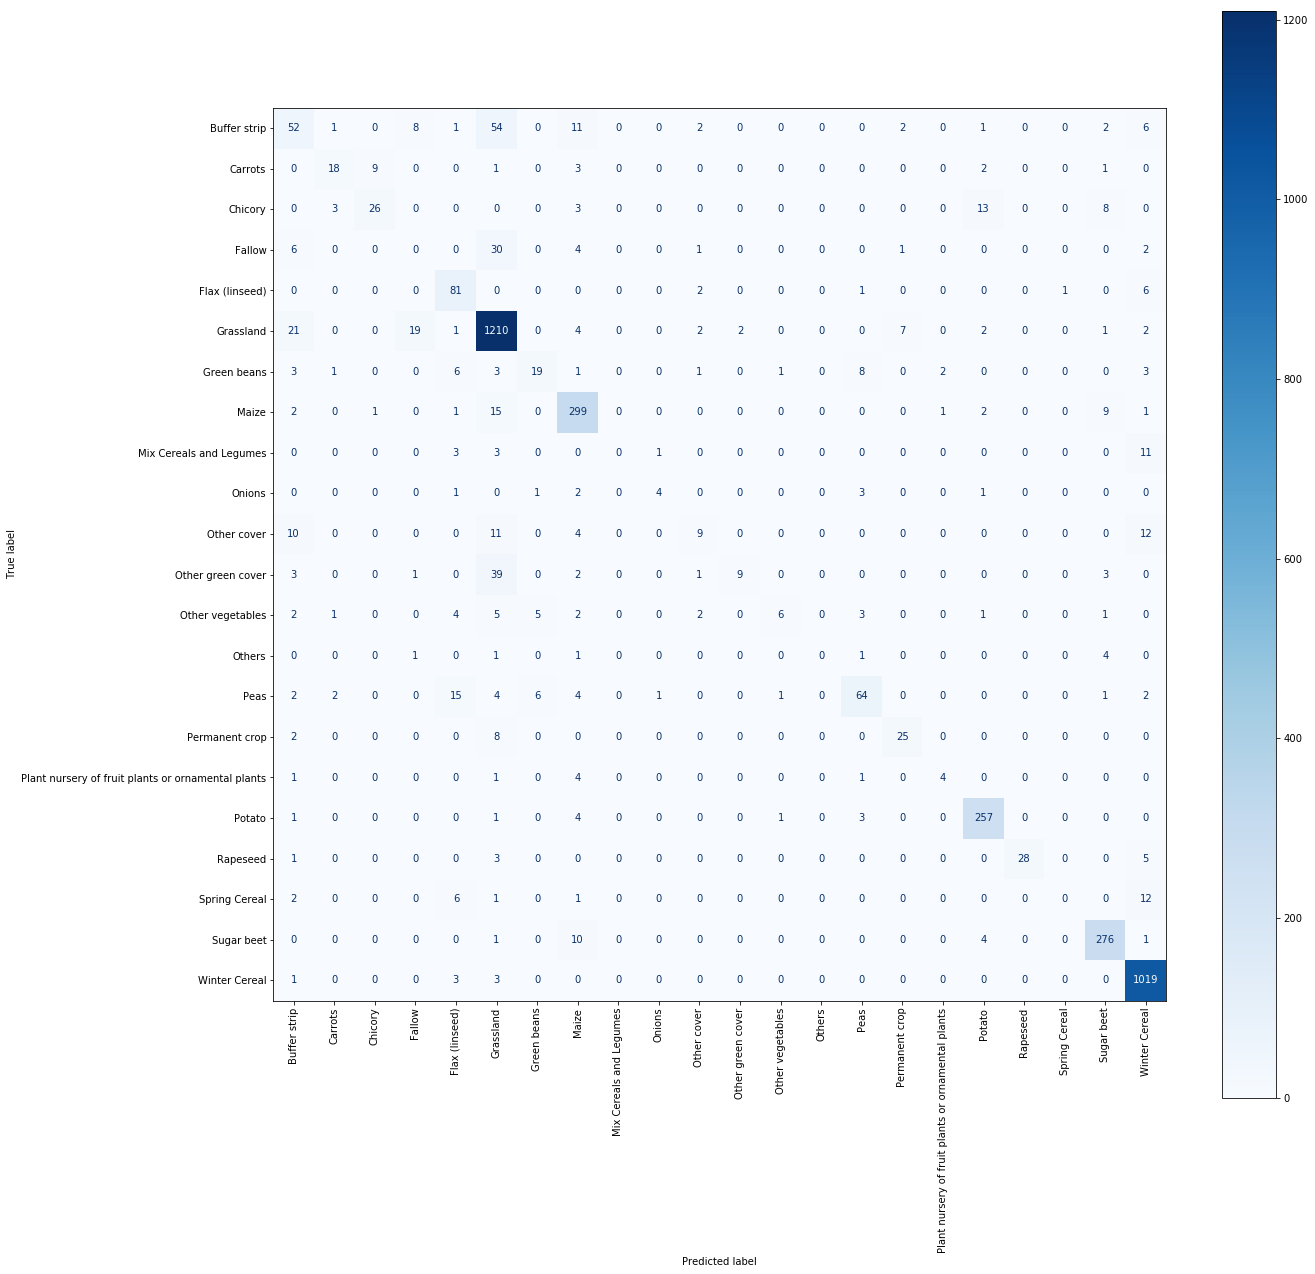

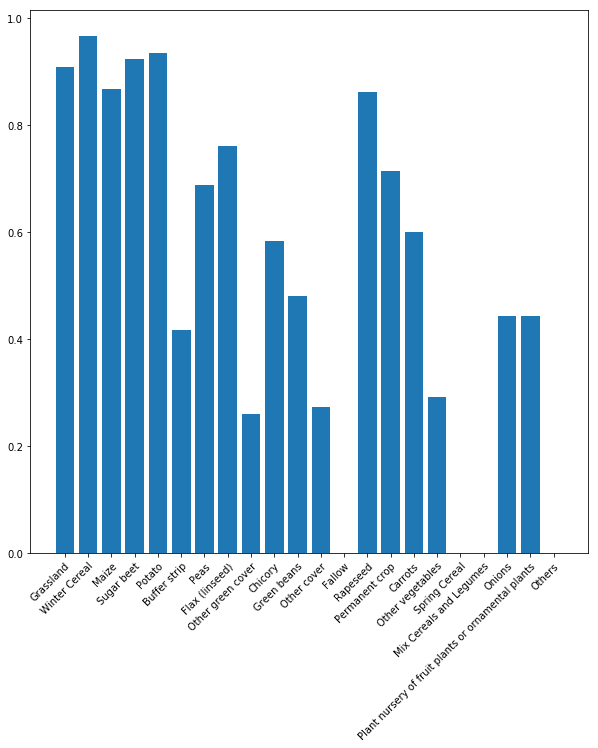

In [69]:
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train, y_train)
show_results(clf_KNN, X_test, y_test)

## 9.3 - SVC

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.43      0.04      0.08       140
                                           Carrots       0.87      0.38      0.53        34
                                           Chicory       0.27      0.06      0.09        53
                                            Fallow       0.00      0.00      0.00        44
                                    Flax (linseed)       0.74      0.98      0.84        91
                                         Grassland       0.81      0.99      0.89      1271
                                       Green beans       0.78      0.15      0.25        48
                                             Maize       0.84      0.93      0.88       331
                           Mix Cereals and Legumes       0.00      0.00      0.00        18
                                            Onions       0.00      0.00      0.

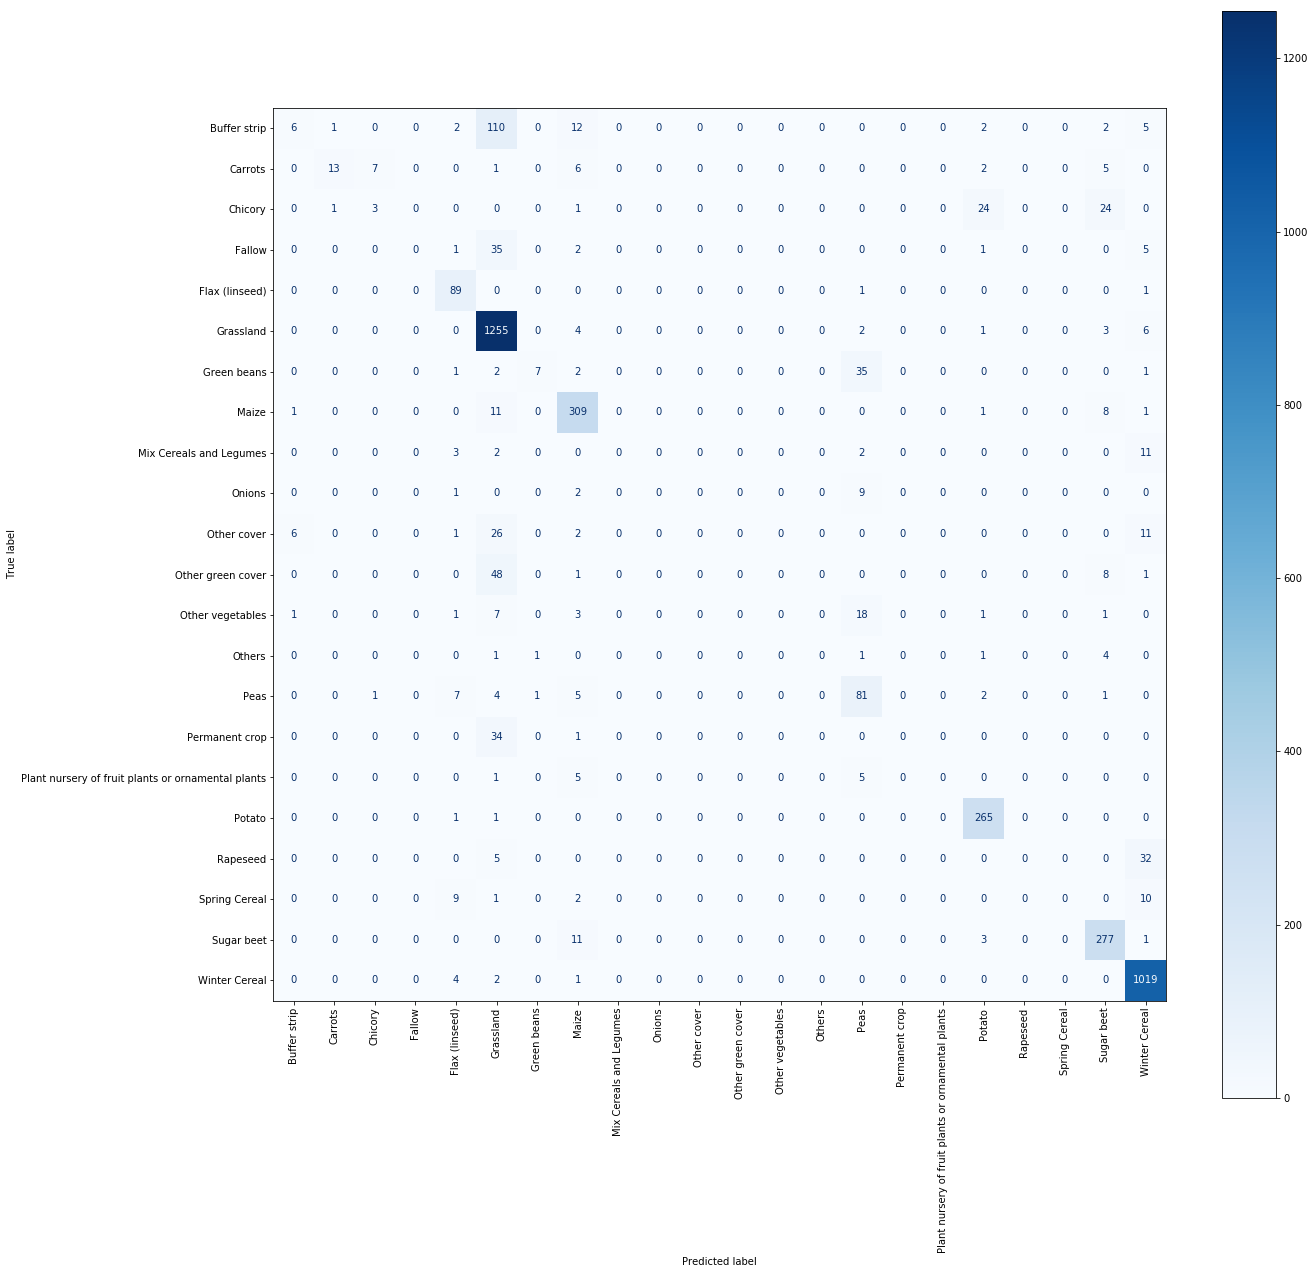

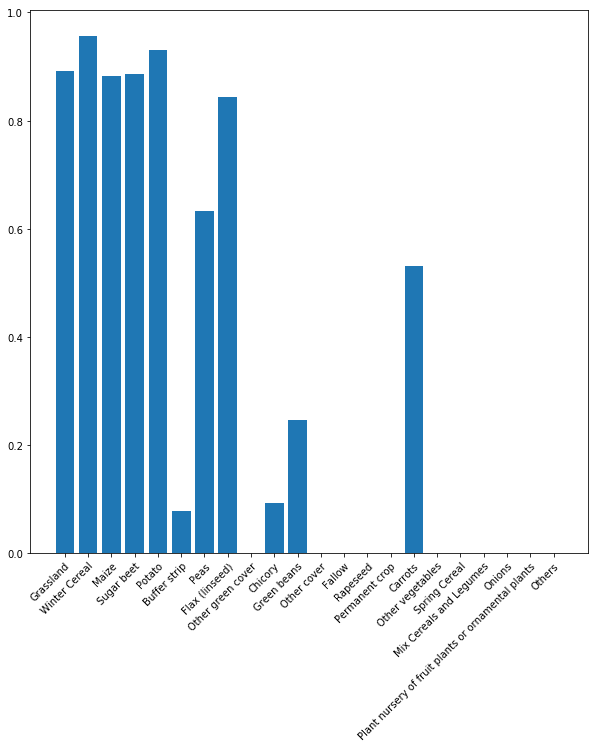

In [70]:
clf_SVC = SVC(random_state=42)
clf_SVC.fit(X_train, y_train)
show_results(clf_SVC, X_test, y_test)

## 9.4 - MLPClassifier

                                                    precision    recall  f1-score   support

                                      Buffer strip       0.24      0.56      0.33       140
                                           Carrots       0.60      0.53      0.56        34
                                           Chicory       0.54      0.89      0.67        53
                                            Fallow       0.07      0.25      0.11        44
                                    Flax (linseed)       0.79      0.73      0.75        91
                                         Grassland       0.95      0.62      0.75      1271
                                       Green beans       0.68      0.48      0.56        48
                                             Maize       0.97      0.71      0.82       331
                           Mix Cereals and Legumes       0.02      0.06      0.03        18
                                            Onions       1.00      0.17      0.

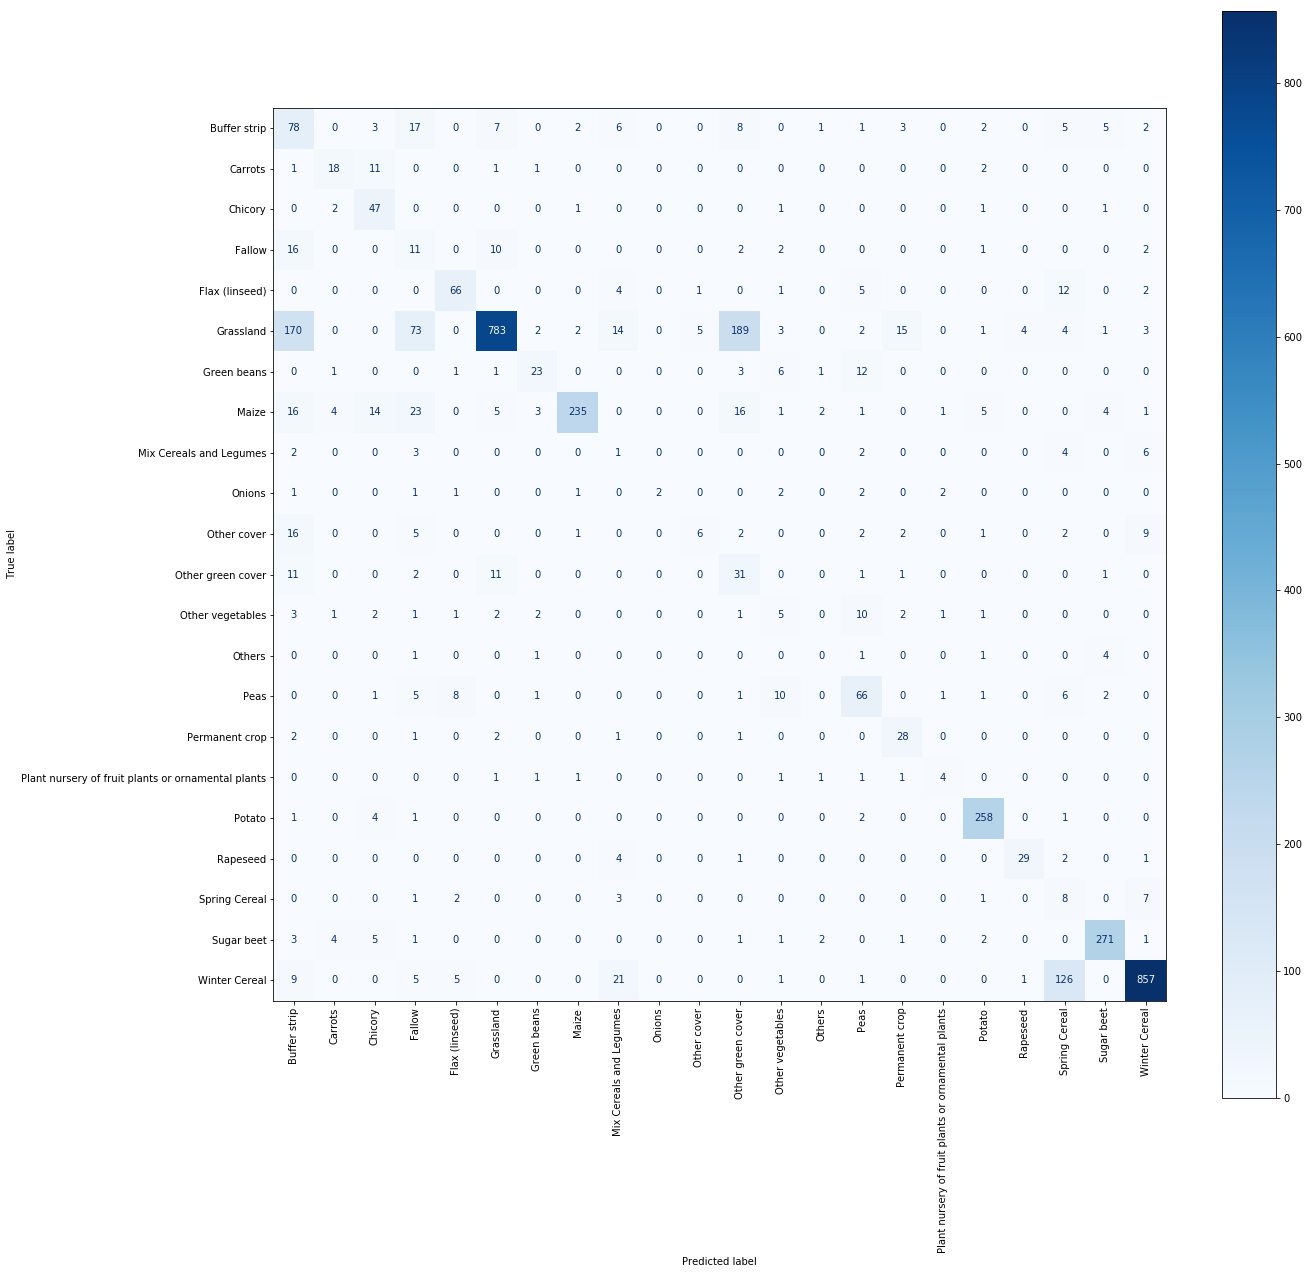

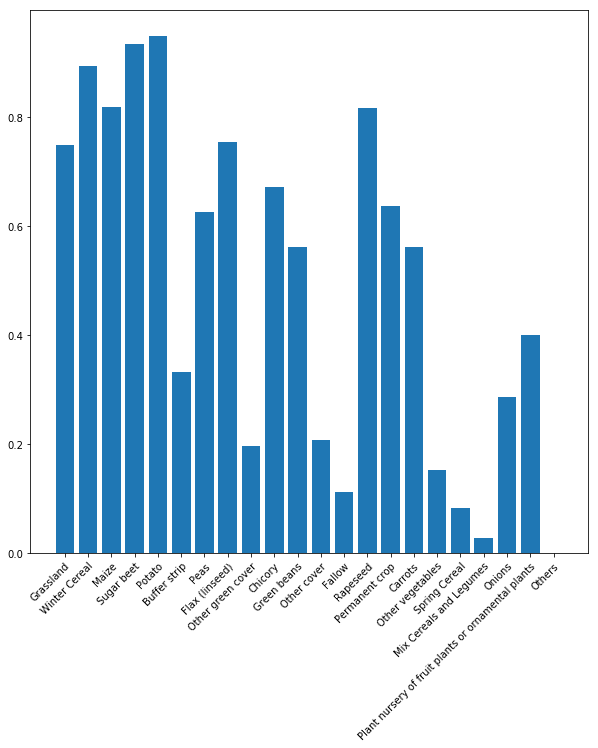

In [71]:
clf_MLP = MLPClassifier(random_state=42)
clf_MLP.fit(X_train, y_train)
show_results(clf_MLP, X_test, y_test)